In [1]:
from utils.result import *
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.io import loadmat
from utils.get_data import *
%reload_ext autoreload
%autoreload 2
stimuli = ['0-BEA', '0-BOL', '0-Ctl', '1-DatExt', '0-FAR', '0-GER', '0-ISO', '0-LIN', 
           '0-M2', '0-M3', '0-M4', '0-M5', '0-M6', '0-MAL', '0-MYR', '0-NER', 
           '1-P3', '1-P4', '1-P5', '1-P9', '1-P9_Hund', '1-P9_Ten', '1-P9_TenThous']		

mixture_dict = {"1-P9":["0-BEA","0-BOL","0-MAL","0-MYR","0-LIN","0-NER","0-GER","0-ISO","0-FAR"],
                "1-P5":["0-BEA","0-BOL","0-LIN","0-NER","0-GER"],
                "1-P4":["0-BEA","0-BOL","0-LIN","0-NER"],
                "1-P3":["0-BEA","0-BOL","0-LIN"],
                "0-M6":["0-MAL","0-MYR","0-NER","0-GER","0-ISO","0-FAR"],
                "0-M5":["0-MAL","0-MYR","0-GER","0-ISO","0-FAR"],
                "0-M4":["0-MAL","0-MYR","0-ISO","0-FAR"],
                "0-M3":["0-MAL","0-ISO","0-FAR"],
                "0-M2":["0-BEA","0-BOL"]}


In [2]:
path="/hpc/group/tarokhlab/hy190/data/AL/ALdata/070921_cleaned.csv"
time_resolution=3
df, neurons = read_moth(path, time_resolution)
components =["0-BEA","0-BOL","0-MAL","0-MYR","0-LIN","0-NER","0-GER","0-ISO","0-FAR", "0-DATEXT", "0-CTL"]
mixture_components = {"1-P9":["0-BEA","0-BOL","0-MAL","0-MYR","0-LIN","0-NER","0-GER","0-ISO","0-FAR"],
              "1-P9_TEN":["0-BEA","0-BOL","0-MAL","0-MYR","0-LIN","0-NER","0-GER","0-ISO","0-FAR"],
              "1-P9_HUND":["0-BEA","0-BOL","0-MAL","0-MYR","0-LIN","0-NER","0-GER","0-ISO","0-FAR"],
              "1-P9_TENTHOUS":["0-BEA","0-BOL","0-MAL","0-MYR","0-LIN","0-NER","0-GER","0-ISO","0-FAR"],
              "1-P5":["0-BEA","0-BOL","0-LIN","0-NER","0-GER"],
              "1-P4":["0-BEA","0-BOL","0-LIN","0-NER"],
              "1-P3":["0-BEA","0-BOL","0-LIN"],
              "0-M6":["0-MAL","0-MYR","0-NER","0-GER","0-ISO","0-FAR"],
              "0-M5":["0-MAL","0-MYR","0-GER","0-ISO","0-FAR"],
              "0-M4":["0-MAL","0-MYR","0-ISO","0-FAR"],
              "0-M3":["0-MAL","0-ISO","0-FAR"],
              "0-M2":["0-BEA","0-BOL"]}

df[["label", "stimuli"]].drop_duplicates()
df["label_stim"] = df["label"].astype(str) + "-" + df["stimuli"].str.upper()
all_stimuli_count = df.value_counts("label_stim").to_dict()
all_stimuli_count = dict(sorted(all_stimuli_count.items()))
num_stimuli =  len(all_stimuli_count)

In [3]:
def exponential_smoothing_spike(data_concat, time_resolution, tau=0.05):
    time_scale = 10**time_resolution
    tot_time = data_concat.shape[0]/time_scale
    data_concat_smooth = []
    for n in range(data_concat.shape[-1]):
        cat_temp = np.zeros(data_concat[:,n].shape).reshape(-1,1)
        spike_time_unscaled = np.nonzero(data_concat[:,n])[0]
        target_time = np.diff(spike_time_unscaled)/time_scale
        if spike_time_unscaled.size != 0:
            for t in spike_time_unscaled:
                temp = np.exp(-((np.arange(0,tot_time,1/time_scale)-t/time_scale)/tau)).reshape(-1,1)
                temp[0:t] = 0
                cat_temp += temp
        data_concat_smooth.append(cat_temp)
    data_concat_smooth = np.concatenate(data_concat_smooth, 1)
    return data_concat_smooth

def similarity_measure(data_concat_smooth):
    mat = np.zeros((data_concat_smooth.shape[1],data_concat_smooth.shape[1]))
    for i in range(data_concat_smooth.shape[1]):
        for j in range(i+1, data_concat_smooth.shape[1]):
            top = np.dot(data_concat_smooth[:,i], data_concat_smooth[:,j])
            bot = np.linalg.norm(data_concat_smooth[:,i])*np.linalg.norm(data_concat_smooth[:,j])
            if bot == 0:
                continue
            mat[i,j] = top/bot
            
    return mat

def similarity_measure_shuffle(data_concat_smooth, data_shuffle):
    mat = np.zeros((data_concat_smooth.shape[1],data_concat_smooth.shape[1]))
    for i in range(data_concat_smooth.shape[1]):
        for j in range(i+1, data_shuffle.shape[1]):
            top = np.dot(data_concat_smooth[:,i], data_shuffle[:,j])
            bot = np.linalg.norm(data_concat_smooth[:,i])*np.linalg.norm(data_shuffle[:,j])
            if bot == 0:
                continue
            mat[i,j] = top/bot
            
    return mat

In [4]:
import glob
df_all = None
neurons_all = None
for csv in glob.glob("/hpc/group/tarokhlab/hy190/data/AL/ALdata/*"):
    if ".csv" in csv and "timestamp" not in csv:
        print(csv)
        path=csv
        time_resolution=3
        df, neurons = read_moth(path, time_resolution)
        neurons_csv = [csv + n for n in neurons]
        name_mapper = {neurons[i]: neurons_csv[i] for i in range(len(neurons))}
        df = df.rename(columns=name_mapper)
        if "P9_THOUS" in set(df['stimuli'].str.upper().to_list()):
            print(csv)
            continue
        df[["label", "stimuli"]].drop_duplicates()
        df["label_stim"] = df["label"].astype(str) + "-" + df["stimuli"].str.upper()
        if df_all is not None:
            df_all = pd.concat([df_all, df], axis=1)
            neurons_all += neurons_csv
        else:
            df_all = df
            neurons_all = neurons_csv
        all_stimuli_count = df.value_counts("label_stim").to_dict()
        all_stimuli_count = dict(sorted(all_stimuli_count.items()))
        num_stimuli =  len(all_stimuli_count)

df = df_all.copy()
df = df.loc[:,~df.columns.duplicated()].copy()

            

/hpc/group/tarokhlab/hy190/data/AL/ALdata/070924_1_cleaned.csv
/hpc/group/tarokhlab/hy190/data/AL/ALdata/070921_cleaned.csv
/hpc/group/tarokhlab/hy190/data/AL/ALdata/070922_cleaned.csv
/hpc/group/tarokhlab/hy190/data/AL/ALdata/070906_cleaned.csv
/hpc/group/tarokhlab/hy190/data/AL/ALdata/070913_cleaned.csv
/hpc/group/tarokhlab/hy190/data/AL/ALdata/070924_2_cleaned.csv
/hpc/group/tarokhlab/hy190/data/AL/ALdata/071002_cleaned.csv
/hpc/group/tarokhlab/hy190/data/AL/ALdata/071002_cleaned.csv


In [7]:

taus = np.array(list(range(2,11)))/1000
all_tau_list = []
for tau in taus:
    sim_result = {}
    dur_stim = []
    all_stim_sync_index = []
    triu_index = np.triu_indices(14,1)
    for s_index, s in enumerate(all_stimuli_count):
        # One hot encoding with components
        sim_result[s] = []
        for run in range(all_stimuli_count[s]):
            data_concat_has_spike, neurons_has_spike = make_spiketrain(df, 
                                                                    s,
                                                                    run,
                                                                    neurons_all, 
                                                                    time_resolution, 
                                                                    0,
                                                                    False)
            
            data_concat_smooth = exponential_smoothing_spike(data_concat_has_spike,time_resolution,tau=tau)
            sim_mat = similarity_measure(data_concat_smooth[400:800])
            sim_mat_shuffle = []
            for run_shuffle in range(all_stimuli_count[s]):
                if run == run_shuffle: continue
                data_shuffle, neurons_has_spike = make_spiketrain(df, 
                                                                s,
                                                                run_shuffle,
                                                                neurons_all, 
                                                                time_resolution, 
                                                                0,
                                                                False)
                data_shuffle_smooth = exponential_smoothing_spike(data_shuffle,time_resolution,tau=tau)
                sim_mat_shuffle.append(similarity_measure_shuffle(data_concat_smooth[400:800], 
                                                                data_shuffle_smooth[400:800]))
            mean_shuffle = np.mean(sim_mat_shuffle,0)
            after_shuffle = sim_mat - mean_shuffle
            sim_result[s].append(after_shuffle)
        all_stim_sync_index.append(np.mean(sim_result[s],0)[triu_index].flatten())
    all_tau_list.append((sim_result,all_stim_sync_index))

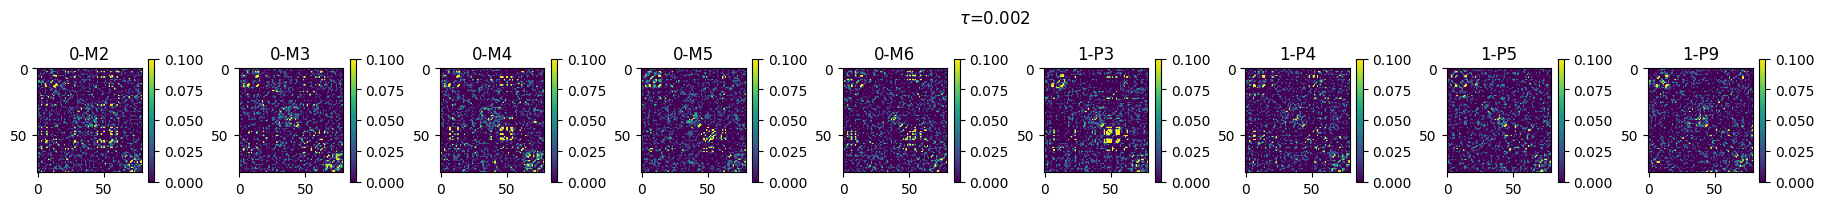

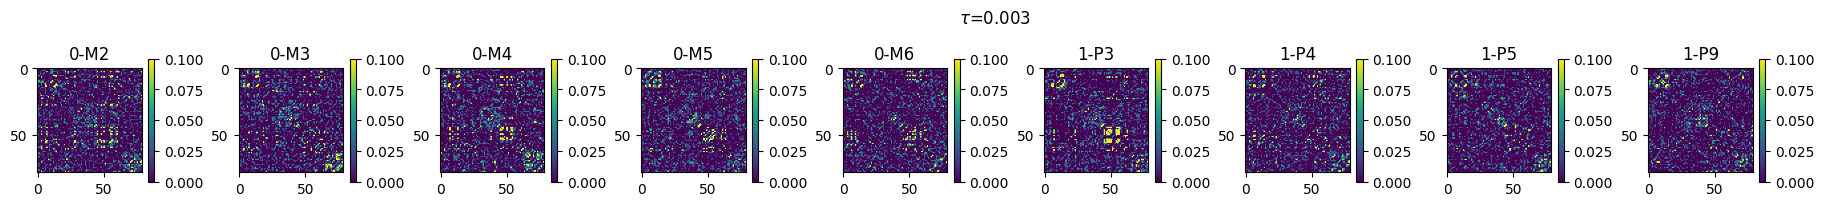

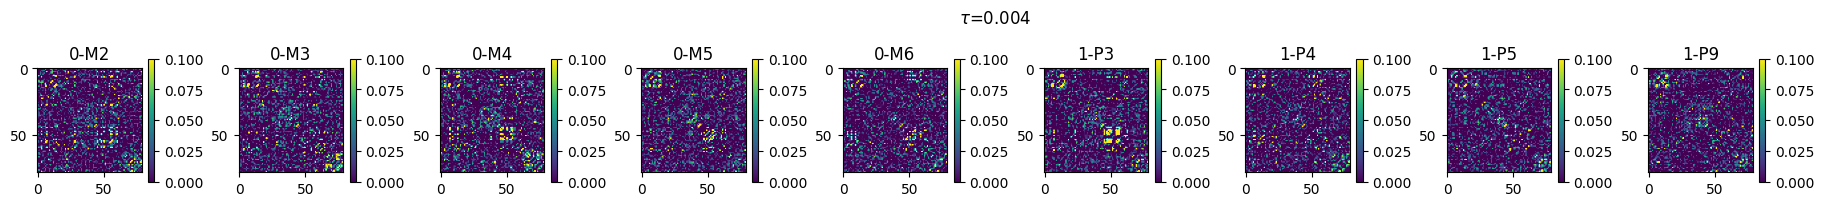

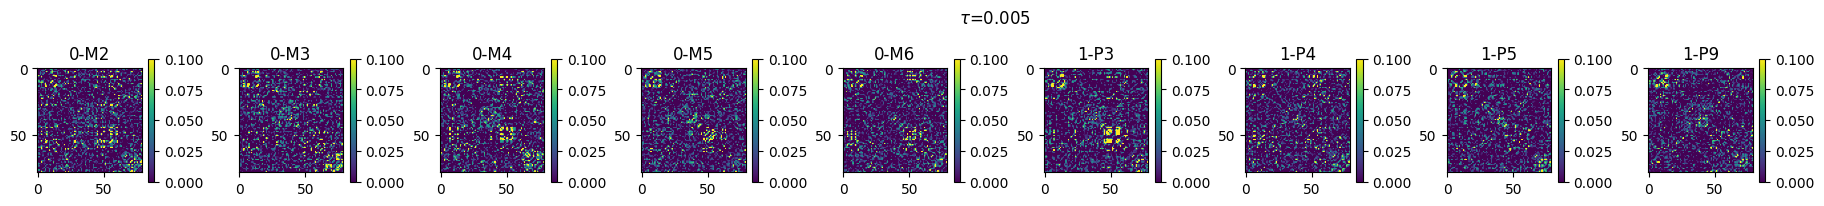

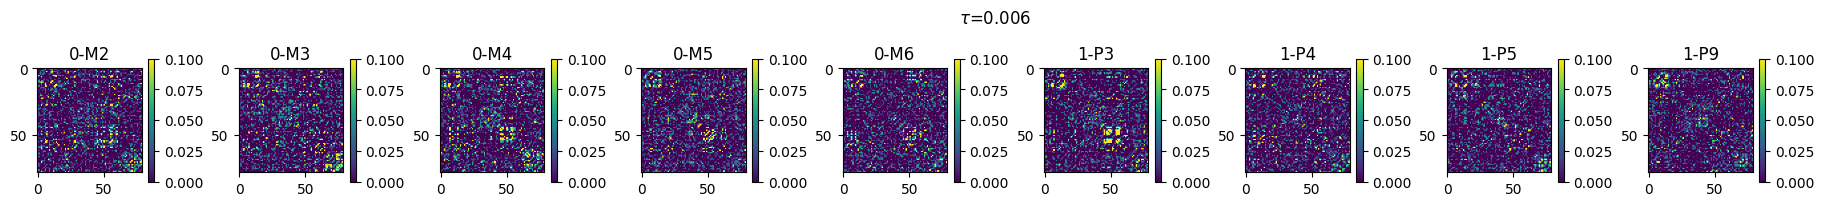

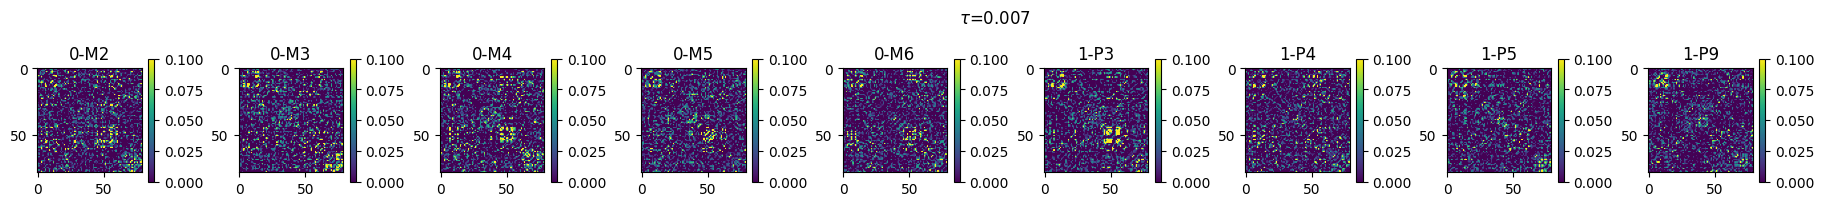

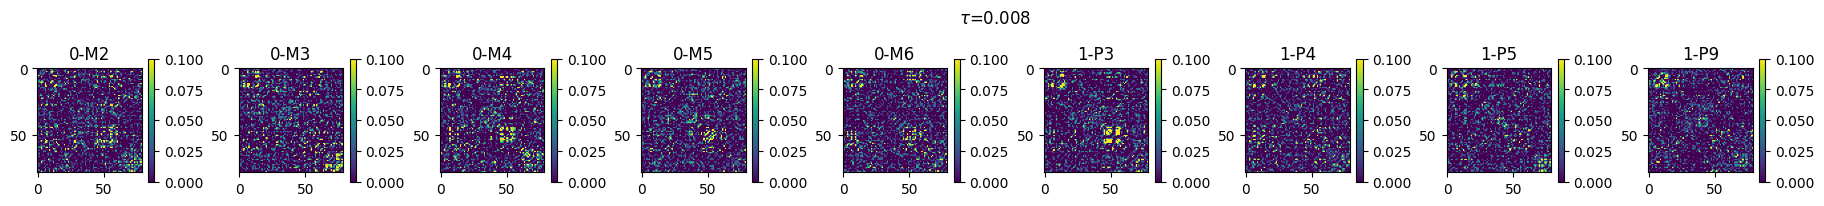

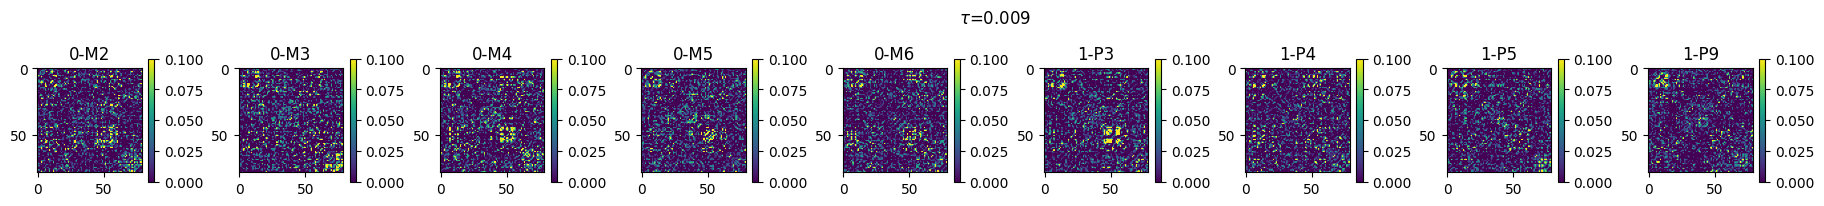

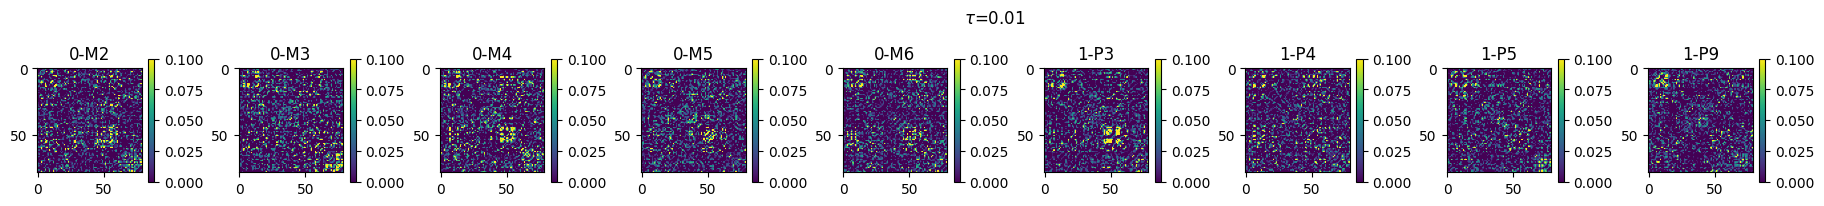

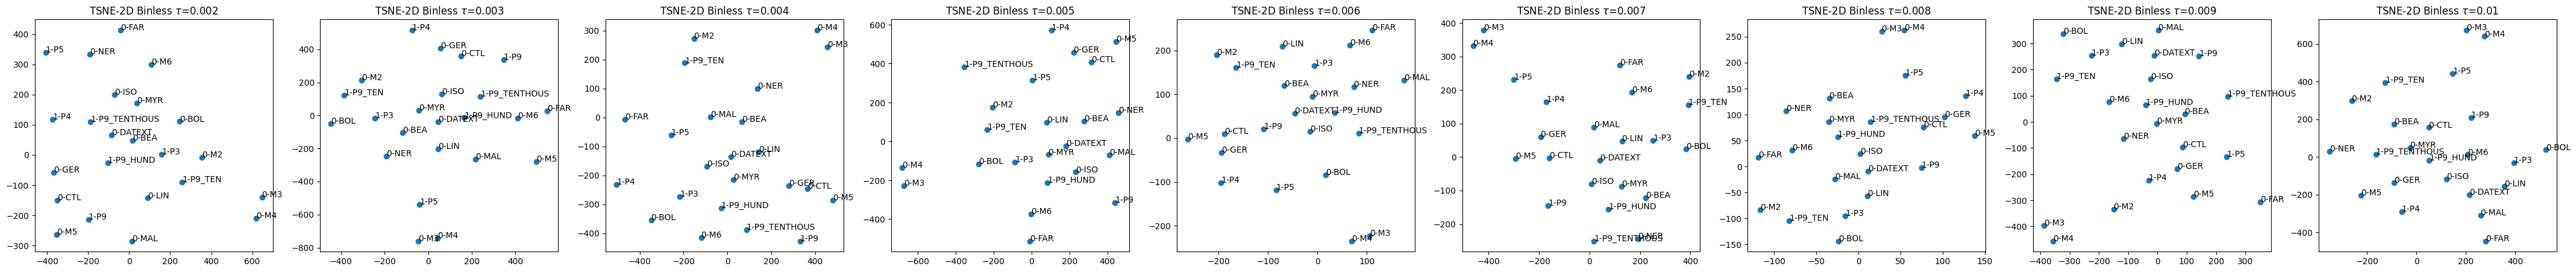

In [8]:
stim_int = ["1-DatExt",	"1-P9",	"1-P5",	"1-P4",	"1-P3",
            "0-M6",	"0-M5",	"0-M4",	"0-M3",	"0-M2"]
for i, tau in enumerate(taus):
    triu_index = np.triu_indices(14,1)
    count = 1
    plt.figure(figsize=(20,2))
    sim_result = all_tau_list[i][0]
    for i,stim in enumerate(sim_result):
        if stim in stim_int:
            empty_mat=np.mean(sim_result[stim],0)#
            full_mat = empty_mat + empty_mat.T
            plt.subplot(1,10,count)
            plt.imshow(full_mat, vmin=0, vmax=0.1)
            plt.title(stim)
            plt.colorbar()
            count += 1
    plt.suptitle(r'$\tau$={}'.format(tau))
    plt.tight_layout()
    
fig, axes = plt.subplots(figsize=(6*len(taus),5), ncols=len(taus))
count = 0
for i, tau in enumerate(taus):
    all_stim_sync_index = np.array(all_tau_list[i][1])
    tsne = TSNE(n_components=2, perplexity=5)
    a = tsne.fit_transform(all_stim_sync_index)
    axes[count].scatter(a[:,0], a[:,1])
    for j in range(0, len(a)):
        axes[count].annotate(list(sim_result.keys())[j], (a[j,0], a[j,1]))
    axes[count].set_title("TSNE-2D Binless " + r'$\tau$={}'.format(tau))
    count += 1
#plt.savefig("2dTSNE_binless.pdf", bbox_inches="tight")

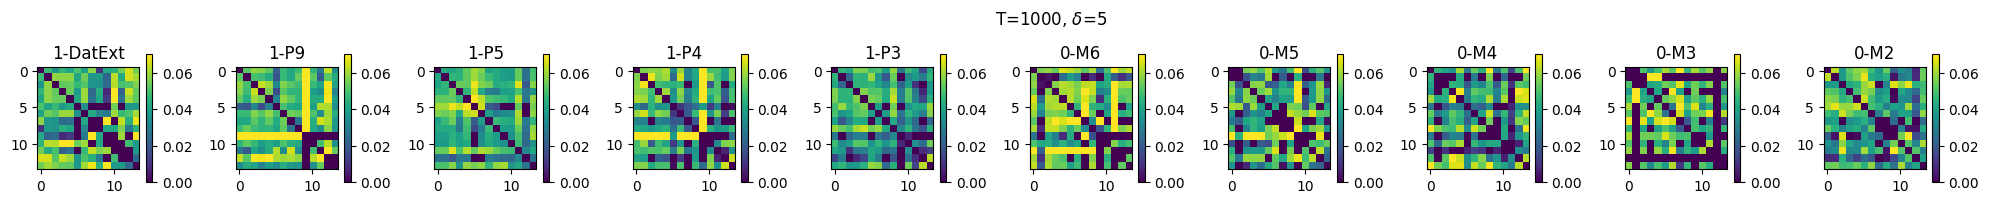

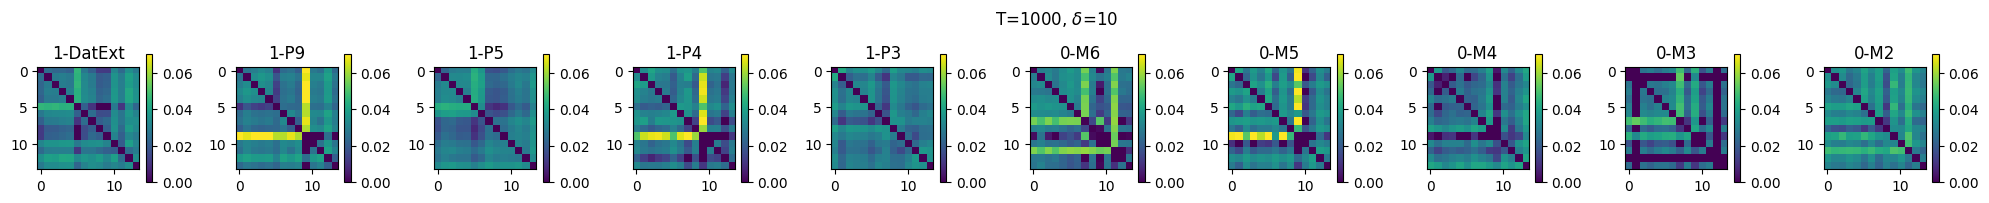

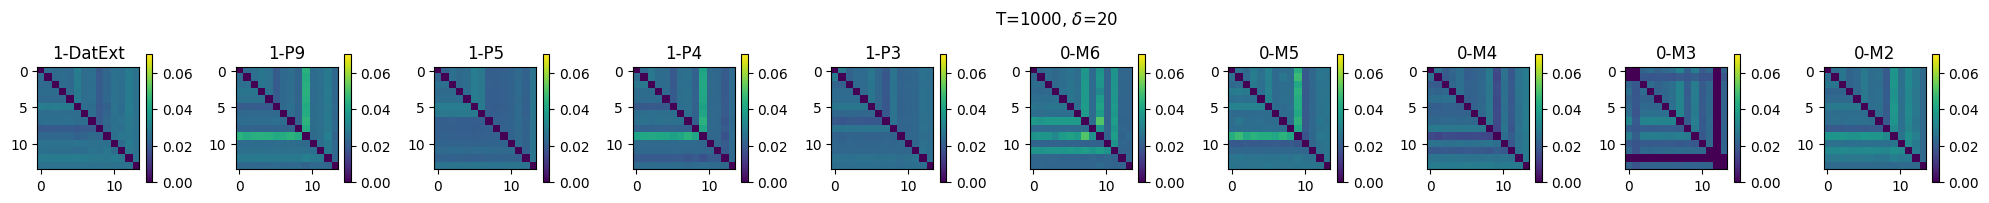

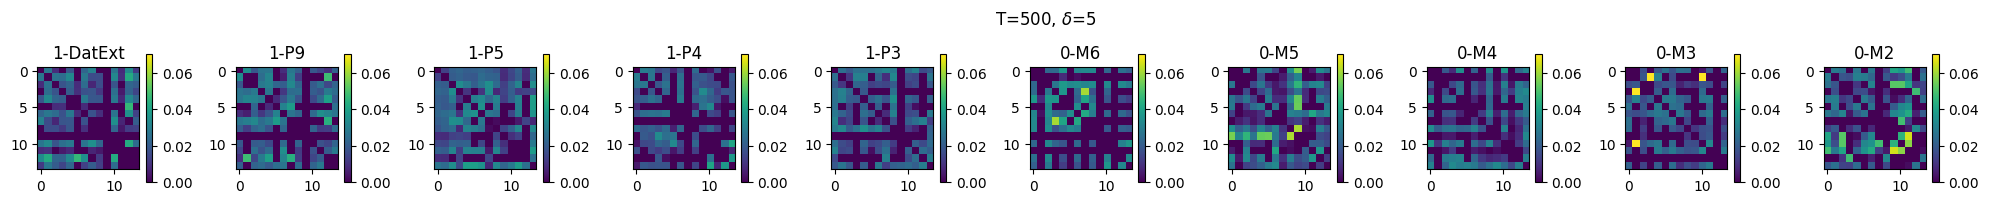

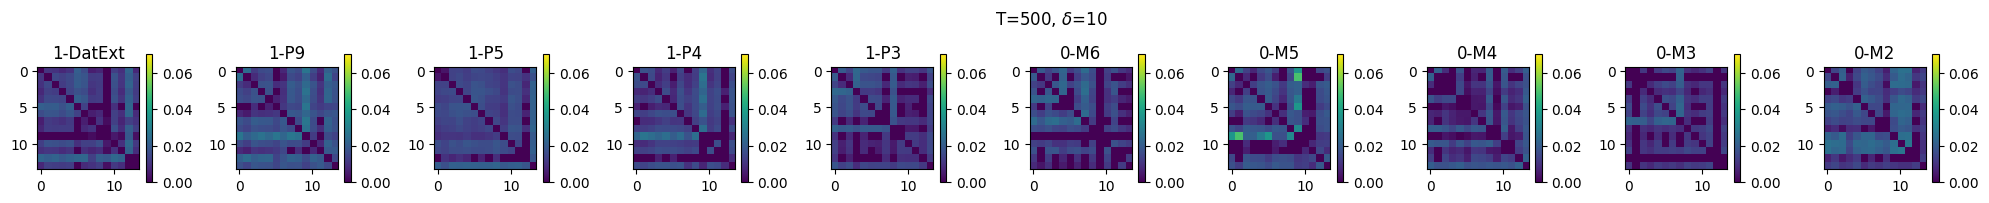

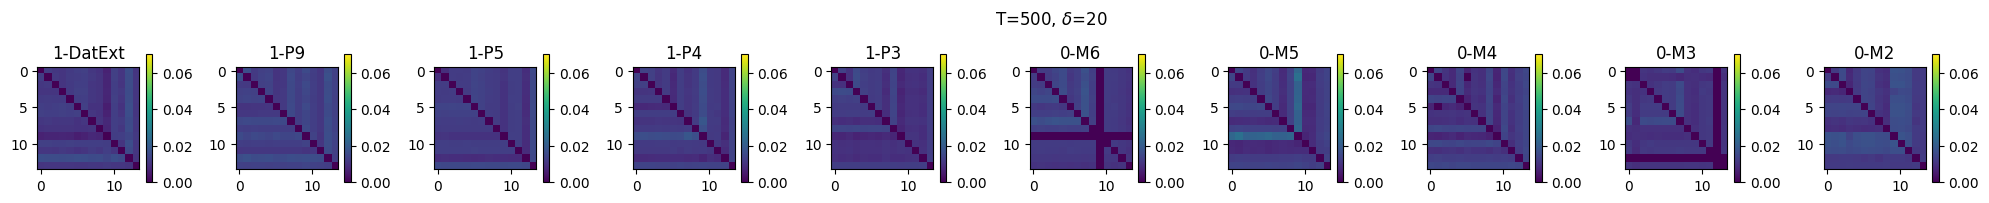

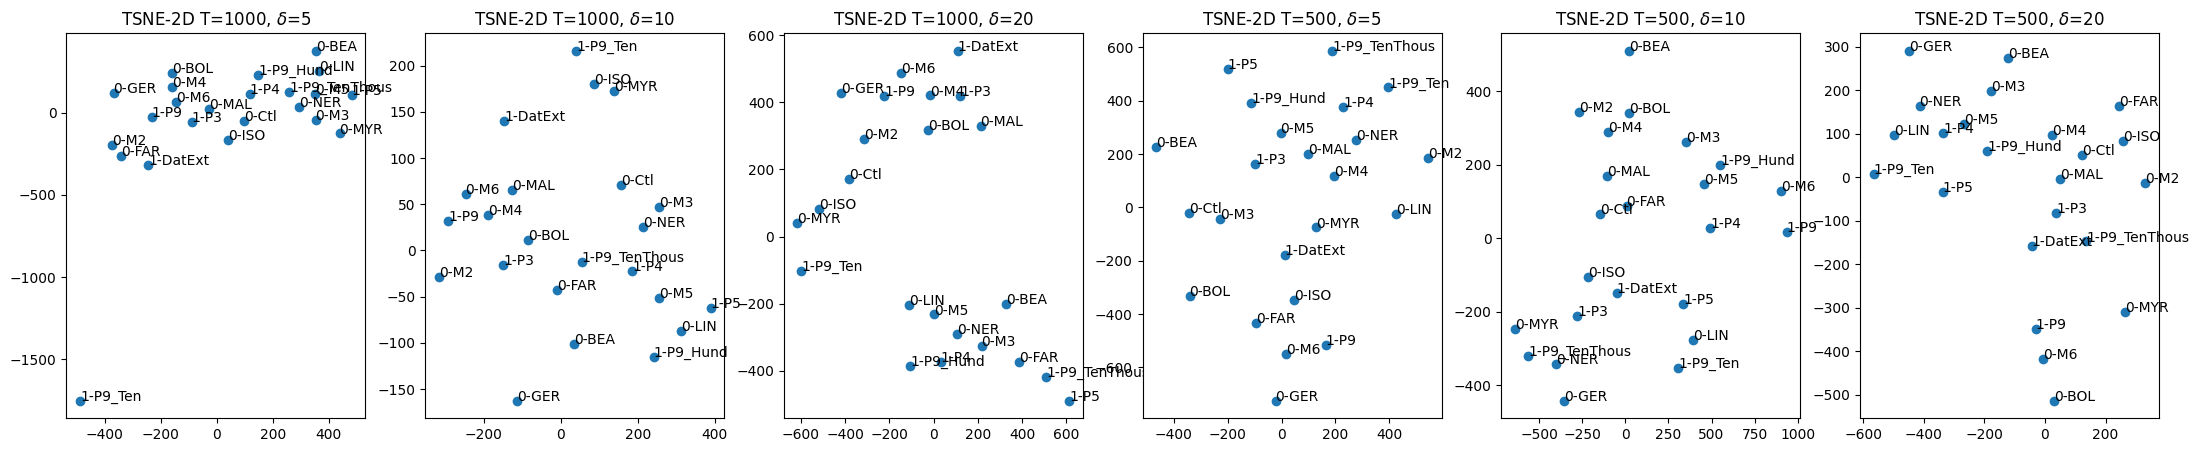

In [38]:
unsort_stim = ["0-Bea",	"0-Bol",	"0-Mal",	"0-Myr",	"0-Lin",	"0-Ner",	"0-Ger",	
               "0-Iso",	"0-Far",	"1-DatExt",	"1-P9",	"1-P9_Ten",	"1-P9_Hund",	
               "1-P9_TenThous",	"0-Ctl",	"1-P5",	"1-P4",	"1-P3",	"0-M6",	"0-M5",	"0-M4",	"0-M3",	"0-M2"]

stim_int = ["1-DatExt",	"1-P9",	"1-P5",	"1-P4",	"1-P3",
            "0-M6",	"0-M5",	"0-M4",	"0-M3",	"0-M2"]
sync_index = loadmat("070921_cleaned/sync_index_070921.mat")
triu_index = np.triu_indices(14,1)
all_stim_sync_index = []

numseq = [5,10]
binsize= [5,10,20]



for ns in numseq:
    for bs in binsize:
        count = 1
        plt.figure(figsize=(20,2))
        for i,stim in enumerate(unsort_stim):
            if stim in stim_int:
                empty_mat = np.zeros((14,14))
                empty_mat[triu_index] = sync_index["sync_index_070921_{}_{}".format(ns, bs)][i,:]
                full_mat = empty_mat + empty_mat.T
                all_stim_sync_index.append(full_mat)
                plt.subplot(1,10,count)
                plt.imshow(full_mat, vmin=0, vmax=0.07)
                plt.title(unsort_stim[i])
                plt.colorbar()
                count += 1
        plt.suptitle("T={}, ".format(int(5000/ns)) + r'$\delta$={}'.format(bs),horizontalalignment="left")
        plt.tight_layout()
        plt.savefig("sync_index_{}_{}.pdf".format(ns, bs))

sync_index_values = sync_index["sync_index_070921_10_5"]
tsne = TSNE(n_components=2, perplexity=5)
a = tsne.fit_transform(sync_index_values)
fig, axes = plt.subplots(figsize=(27,5), ncols=6)
count = 0
for ns in numseq:
    for bs in binsize:
        sync_index_values = sync_index["sync_index_070921_{}_{}".format(ns, bs)]
        tsne = TSNE(n_components=2, perplexity=5)
        a = tsne.fit_transform(sync_index_values)
        axes[count].scatter(a[:,0], a[:,1])
        for i in range(0, len(a)):
            axes[count].annotate(stimuli[i], (a[i,0], a[i,1]))
            
        axes[count].set_title("TSNE-2D T={}, ".format(int(5000/ns)) + r'$\delta$={}'.format(bs))
        count += 1
        
plt.savefig("2dTSNE_sync_index.pdf", bbox_inches="tight")